<a href="https://colab.research.google.com/github/aatika-hakim/chatbots/blob/main/customer_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install langgraph langchain_google_genai langchain_community

In [35]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [36]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [37]:
graph_builder = StateGraph(State)

In [38]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
# llm.invoke("hi").content
from google.colab import userdata

api_key = userdata.get('GROQ_API_KEY')

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=1, api_key= api_key)
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [39]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

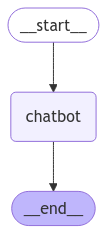

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: LangGraph is a social network platform focused on language learning. The platform utilizes AI-powered tools to facilitate global connections and interactions between users of different linguistic backgrounds. 

Some key features of LangGraph include:

1. Language Learning: Users can learn languages by interacting with native speakers, practicing conversational skills, and using AI-powered language learning tools.
2. Social Networking: LangGraph allows users to connect with others who share similar language interests and goals, creating a community-driven environment.
3. Language Exchange: Users can practice their target languages by engaging in conversations and exchanging messages with native speakers, fostering language immersion and cultural exchange.
4. AI-powered Tools: LangGraph incorporates AI-driven features to enhance the language learning experience, such as task suggestions, conversation prompts, and progress analysis.
5. Ga

In [43]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [33]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello. How can I assist you today?
User: what is biryani
Assistant: Biryani is a popular South Asian mixed rice dish made with a combination of basmati rice, spices, and usually meat or vegetables. It is a flavorful and aromatic dish that originated in the Indian subcontinent and has since spread to other parts of the world.

The word "biryani" is derived from the Persian word "birian," which means "fried" or "roasted." The dish is typically made by layering cooked rice with a mixture of meat or vegetables, spices, and sometimes eggs, onions, and ghee (clarified butter). The layers are then stacked in a pot or vessel, and the dish is cooked over low heat, allowing the flavors to meld together.

There are many different types of biryani, and the ingredients and cooking methods can vary greatly depending on the region and personal preferences. Some popular types of biryani include:

1. Hyderabadi biryani: A spicy and flavorful biryani made with lamb or beef, and is

In [ ]:
import re

# Define customer support keywords or intents
SUPPORT_KEYWORDS = [
    "complaint", "refund", "support", "issue", "problem",
    "help", "order", "billing", "payment", "service"
]

# Function to check if input is a customer support query
def is_customer_support_query(user_input):
    user_input = user_input.lower()
    return any(keyword in user_input for keyword in SUPPORT_KEYWORDS)

# Function to process customer support queries
def handle_customer_support(user_input):
    if "complaint" in user_input:
        return "Please describe your issue, including the product and your preferred resolution."
    elif "refund" in user_input:
        return "To process a refund, we need the order ID and the reason for the refund."
    elif "help" in user_input:
        return "How can I assist you today? You can ask about complaints, refunds, or other support issues."
    else:
        return "Can you provide more details about your support request?"

# Main chatbot loop
def customer_support_chatbot():
    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye! Have a great day!")
                break

            # Check if the input is a valid support query
            if is_customer_support_query(user_input):
                response = handle_customer_support(user_input)
            else:
                response = "I'm here to assist with customer support issues only. Please ask a relevant question."

            print("Chatbot:", response)

        except Exception as e:
            print(f"Error: {str(e)}")
            break

# Run the chatbot
customer_support_chatbot()


User: hello
Chatbot: I'm here to assist with customer support issues only. Please ask a relevant question.
User: what is biryani
Chatbot: I'm here to assist with customer support issues only. Please ask a relevant question.
